In [ ]:
import requests
import  geopandas as gpd
import pandas as pd
import glob

In [ ]:
url = "https://www2.census.gov/geo/tiger/TIGER2021/STATE/tl_2021_us_state.zip"
response = requests.get(url)
with open("tl_2021_us_state.zip", "wb") as file:
    file.write(response.content)

!unzip tl_2021_us_state.zip

In [32]:
# Load the US states shapefile
states = gpd.read_file("tl_2021_us_state.shp")  # Replace with your shapefile path

# Filter for Northeastern US states
northeast_states = states[states['NAME'].isin([
    'New York', 'Vermont',
    'New Hampshire', 'Massachusetts', 'Connecticut',
    'Rhode Island', 'Maine'
])]

# Dissolve to create a single geometry for the Northeastern US
northeast_boundary = northeast_states.dissolve()

<Axes: >

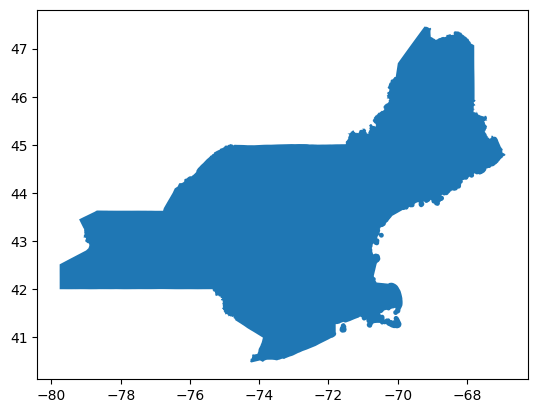

In [6]:
northeast_boundary.plot()

In [13]:
urls=[
    "https://apps.fs.usda.gov/fia/datamart/CSV/NY_PLOT.csv",
    "https://apps.fs.usda.gov/fia/datamart/CSV/NH_PLOT.csv",
    "https://apps.fs.usda.gov/fia/datamart/CSV/VT_PLOT.csv",
    "https://apps.fs.usda.gov/fia/datamart/CSV/MA_PLOT.csv",
    "https://apps.fs.usda.gov/fia/datamart/CSV/RI_PLOT.csv",
    "https://apps.fs.usda.gov/fia/datamart/CSV/CT_PLOT.csv",
    "https://apps.fs.usda.gov/fia/datamart/CSV/ME_PLOT.csv",
]

In [15]:
for url in urls:
  response = requests.get(url)
  with open(url[42:], "wb") as file:
      file.write(response.content)

In [19]:
csv_list = glob.glob('*.csv')

In [25]:
plot_list=[]
for csv in csv_list:
  df = pd.read_csv(csv)
  df=df[df['MEASYEAR']==2022]
  plot_list.append(df[['LON','LAT']])
plots=pd.concat(plot_list)

In [39]:
from shapely.geometry import Point
import geopandas as gpd


# Step 1: Create GeoDataFrame with point geometry
plots_gdf = gpd.GeoDataFrame(
    plots,
    geometry=[Point(lon, lat) for lon, lat in zip(plots["LON"], plots["LAT"])],
    crs="EPSG:4326"  # WGS 84
)

# Step 2: Convert to projected CRS (e.g., UTM Zone 19N) for accurate buffering
plots_gdf = plots_gdf.to_crs(epsg=32619)

# Step 3: Create buffers (0.5 miles ≈ 804.67 meters)
plots_gdf["buffer"] = plots_gdf.geometry.buffer(804.67)

# Step 4: Change the geometry to the buffered polygons
plots_gdf = plots_gdf.set_geometry("buffer")

# Step 5: Reproject back to WGS 84 for visualization/export if needed
plots_gdf = plots_gdf.to_crs(epsg=4326)

# Display the updated GeoDataFrame
print(plots_gdf[["LON", "LAT", "geometry"]])


             LON        LAT                         geometry
5386  -72.085070  44.355106   POINT (254134.426 4915944.743)
5388  -72.378630  44.494872    POINT (231380.04 4932393.551)
5390  -72.054647  44.681103    POINT (257913.944 4952065.82)
5391  -72.000443  44.489189    POINT (261425.37 4930587.946)
5393  -72.146719  44.274024   POINT (248875.273 4907125.289)
...          ...        ...                              ...
23607 -77.264770  42.673246  POINT (-177394.564 4757766.649)
23614 -78.589704  42.602265   POINT (-286963.26 4761447.382)
23615 -77.836624  42.622998   POINT (-224880.514 4756961.61)
23620 -76.259877  42.383252   POINT (-97769.943 4717930.359)
23622 -75.800289  43.346249   POINT (-51232.274 4821774.865)

[2091 rows x 3 columns]


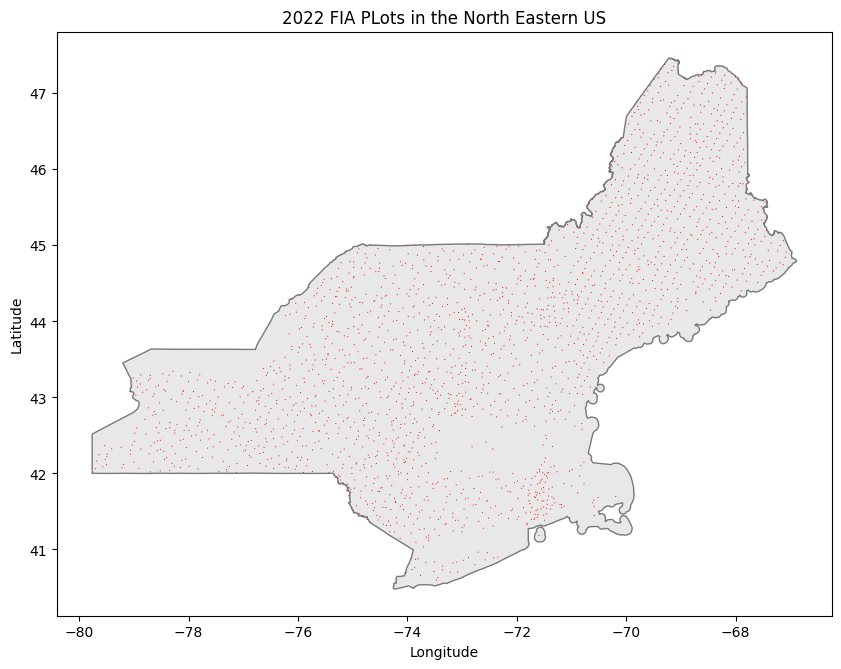

In [49]:
import matplotlib.pyplot as plt
# Ensure both datasets have the same CRS
northeast_boundary = northeast_boundary.to_crs(plots_gdf.crs)

# Step 4: Plot the result
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the Northeastern U.S. boundary
northeast_boundary.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

# Plot points and buffers inside the Northeastern boundary
plots_gdf.plot(ax=ax, color='red')

plt.title("2022 FIA PLots in the North Eastern US")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
plots_gdf['geometry'].to_file("/content/drive/MyDrive/Data/FIA_Plots.shp", driver="ESRI Shapefile")